# Laboratorio di Simulazione Numerica: esercizio 11.3

Elia steve (47122A)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects

2024-09-17 16:33:38.979988: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In questo esericzio dobbiamo usare una rete neurale per effettuare un fit di dati in 3D che seguono la legge

$$z=\sin(x^2+y^2),\quad(x, y) \in [-3/2, 3/2]^2$$

Creo i dati di training e di validazione (a cui aggiungo del rumore gaussiano con $\sigma=0.1$):

In [2]:
rng = np.random.default_rng(42)
keras.utils.set_random_seed(42)

In [3]:
n_train = 1000
n_test = 100

In [4]:
def f(x, y): return np.sin(x**2+y**2)

In [5]:
x_train = rng.uniform(-1.5, 1.5, (n_train, 2))
#x_train.sort()
y_train = np.array([f(x, y) for (x, y) in x_train]) + rng.normal(0, 0.1, n_train)
x_test = rng.uniform(-1.5, 1.5, (n_test, 2))
y_test = np.array([f(x, y) for (x, y) in x_test]) + rng.normal(0, 0.1, n_test)

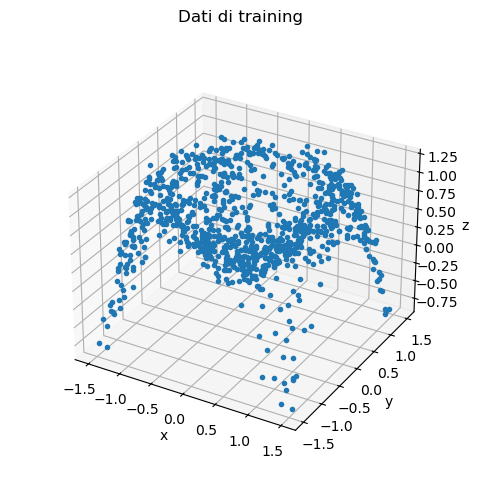

In [6]:
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection="3d")
ax.plot3D(x_train[..., 0], x_train[..., 1], y_train, ".")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

ax.set_box_aspect(None, zoom=0.85)
ax.set_title("Dati di training")

plt.show()

Text(0.5, 1.0, 'Dati di training (proiezione)')

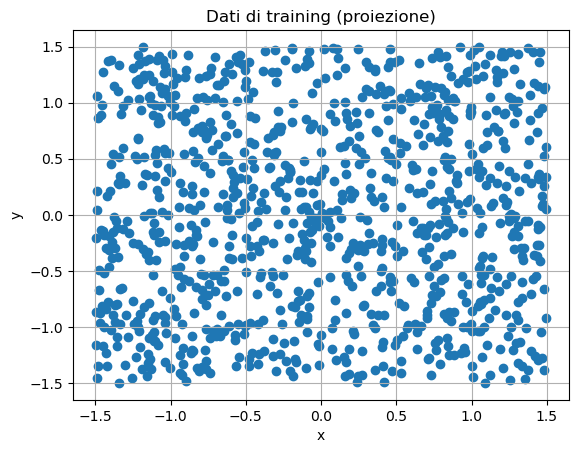

In [7]:
plt.scatter(x_train[..., 0], x_train[..., 1])
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.title("Dati di training (proiezione)")

Text(0.5, 1.0, 'Dati di validazione (proiezione)')

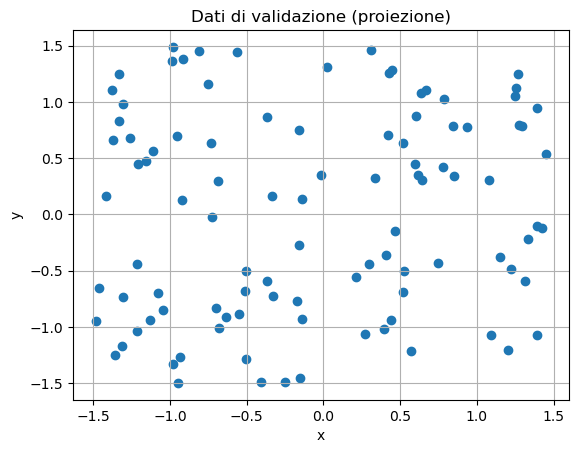

In [8]:
plt.scatter(x_test[..., 0], x_test[..., 1])
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.title("Dati di validazione (proiezione)")

### Addestramento con la discesa stocastica del gradiente

Cominciamo definendo un modello ed addestrandolo con la discesa stocastica del gradiente, usando 300 epoche. Ho deciso di usare per tutti i modelli che seguono l'errore qudratico medio come funzione costo, e di tenere traccia anche del coseno di simulitudine (_cosine similarity_) per i dati di validazione (il coseno di similitudine fra due vettori $\textbf{A}$ e $\textbf{B}$ è il coseno dell'angolo compreso fra di essi, cioè $\cos(\theta) = \frac{\textbf{A}\cdot\textbf{B}}{||\textbf{A}||\,||\textbf{B}||}$).

In [9]:
model_sgd = tf.keras.Sequential()
model_sgd.add(Dense(32, input_shape=(2, ), activation="tanh"))
model_sgd.add(Dense(32, activation="tanh"))
model_sgd.add(Dense(32, activation="tanh"))
model_sgd.add(Dense(1))

2024-09-17 16:33:45.849851: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
model_sgd.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                96        
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,241
Trainable params: 2,241
Non-trainable params: 0
_________________________________________________________________


In [11]:
#opt = keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
model_sgd.compile(
    optimizer="sgd",
    loss=keras.losses.MeanSquaredError(),
    metrics = ["cosine_similarity"]
)

In [12]:
history_sgd = model_sgd.fit(
    x=x_train,
    y=y_train,
    batch_size=32,
    epochs=300,
    validation_data=(x_test, y_test)
)

Epoch 1/300
32/32 [==============================] - 1s 7ms/step - loss: 0.2590 - cosine_similarity: 0.7280 - val_loss: 0.1211 - val_cosine_similarity: 0.8600
Epoch 2/300
32/32 [==============================] - 0s 3ms/step - loss: 0.1667 - cosine_similarity: 0.8400 - val_loss: 0.1164 - val_cosine_similarity: 0.8600
Epoch 3/300
32/32 [==============================] - 0s 4ms/step - loss: 0.1666 - cosine_similarity: 0.8400 - val_loss: 0.1200 - val_cosine_similarity: 0.8600
Epoch 4/300
32/32 [==============================] - 0s 2ms/step - loss: 0.1659 - cosine_similarity: 0.8400 - val_loss: 0.1176 - val_cosine_similarity: 0.8600
Epoch 5/300
32/32 [==============================] - 0s 2ms/step - loss: 0.1664 - cosine_similarity: 0.8400 - val_loss: 0.1163 - val_cosine_similarity: 0.8600
Epoch 6/300
32/32 [==============================] - 0s 3ms/step - loss: 0.1664 - cosine_similarity: 0.8400 - val_loss: 0.1231 - val_cosine_similarity: 0.8600
Epoch 7/300
32/32 [===========================

In [13]:
mse, cos_sim = model_sgd.evaluate(x_test, y_test, batch_size=32, verbose=1)
print()
print("Metriche di validazione:")
print("MSE:", mse)
print("Coseno di similitudine: ", cos_sim)

4/4 [==============================] - 0s 2ms/step - loss: 0.0741 - cosine_similarity: 0.8600

Metriche di validazione:
MSE: 0.07414783537387848
Coseno di similitudine:  0.8600000143051147


Disegno il grafico della funzione costo e del coseno di similitudine in funzione dell'epoca di addestramento:

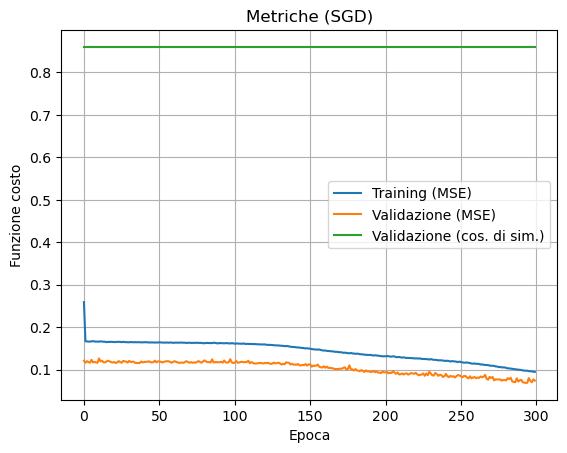

In [14]:
# summarize history for loss
plt.plot(history_sgd.history['loss'])
plt.plot(history_sgd.history['val_loss'])
plt.plot(history_sgd.history['val_cosine_similarity'])
plt.ylabel('Funzione costo')
plt.xlabel('Epoca')
plt.legend(['Training (MSE)', 'Validazione (MSE)', "Validazione (cos. di sim.)"], loc='best')
plt.title("Metriche (SGD)")
plt.grid()
plt.show()

Qui vediamo che le funzioni costo decrescono (o crescono, nel caso del coseno) in funzione dell'epoca, che è il comportamento che ci aspettiamo. Notiamo anche che la funzione costo per i dati di validazione è minore di quella per i dati di training: questo probabilmente è dovuto al fatto che siamo nelle fasi iniziali dell'ottimizzazione (un comportamento analogo si ha anche nelle epoche iniziali dei grafici dei modelli successivi).

Ora confronto le previsioni del modello con i dati esatti:

In [15]:
X = np.linspace(-1.5, 1.5, 50)
Y = np.linspace(-1.5, 1.5, 50)
X_pred, Y_pred = np.meshgrid(X, Y)
Z_model = f(X_pred, Y_pred)
xs = np.array(list(zip(X_pred.flatten(), Y_pred.flatten())))
Z_pred = model_sgd.predict(xs)
Z_pred = np.reshape(Z_pred, (50, 50))

79/79 [==============================] - 0s 856us/step


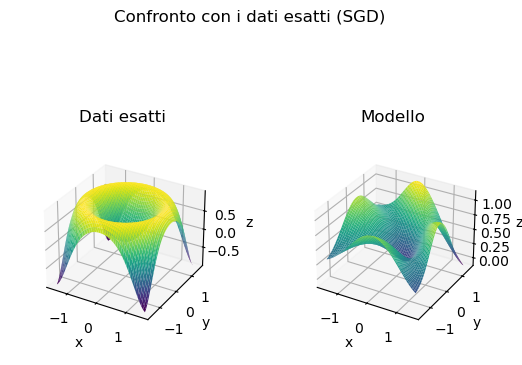

In [16]:
fig=plt.figure()
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(X_pred, Y_pred, Z_model, rstride=1, cstride=1,
                cmap="viridis", edgecolor='none')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_title("Dati esatti")
ax.set_box_aspect(None, zoom=0.80)
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_surface(X_pred, Y_pred, Z_pred, rstride=1, cstride=1,
                cmap="viridis", edgecolor='none')
fig.suptitle("Confronto con i dati esatti (SGD)")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_title("Modello")
ax.set_box_aspect(None, zoom=0.80)

Text(0.5, 0.98, 'Confronto con i dati esatti (SGD)')

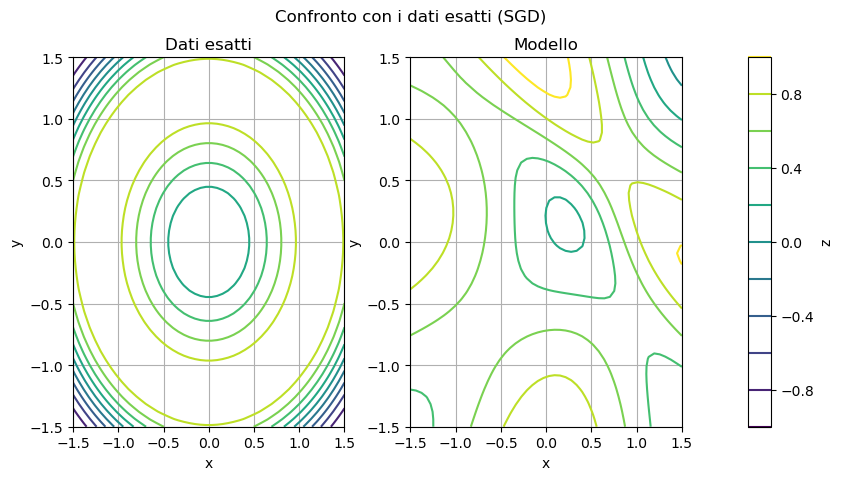

In [17]:
fig, (ax1, ax2, cbar_ax) = plt.subplots(
    nrows=1,
    ncols=3,
    figsize=(9, 4.8), 
    gridspec_kw={
        "width_ratios":[0.48, 0.48, 0.04],
        "wspace":0.35
    }
)
ax1.contour(X_pred, Y_pred, Z_model, levels=np.linspace(-1, 1, 11))
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_title("Dati esatti")
c = ax2.contour(X_pred, Y_pred, Z_pred, levels=np.linspace(-1, 1, 11))
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_title("Modello")
ax1.grid()
ax2.grid()
fig.colorbar(c, cax=cbar_ax, label="z")
fig.suptitle("Confronto con i dati esatti (SGD)")


Vediamo che il modello approssima piuttosto male la funzione esatta.

### Ottimizzazione con Adadelta

Per provare a ottenere un fit migliore, cambiamo ottimizzatore passando ad Adadelta. Costruisco e addestro il modello:

In [18]:
model_adadelta = tf.keras.Sequential()
model_adadelta.add(Dense(32, input_shape=(2, ), activation="tanh"))
model_adadelta.add(Dense(32, activation="tanh"))
model_adadelta.add(Dense(32, activation="tanh"))
model_adadelta.add(Dense(1))

In [19]:
model_adadelta.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 32)                96        
                                                                 
 dense_5 (Dense)             (None, 32)                1056      
                                                                 
 dense_6 (Dense)             (None, 32)                1056      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,241
Trainable params: 2,241
Non-trainable params: 0
_________________________________________________________________


In [20]:
opt = keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
model_adadelta.compile(
    optimizer=opt,
    loss=keras.losses.MeanSquaredError(),
    metrics = ["cosine_similarity"]
)

/opt/anaconda3/envs/mybase/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adadelta.py:79: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [21]:
history_adadelta = model_adadelta.fit(
    x=x_train,
    y=y_train,
    batch_size=32,
    epochs=300,
    validation_data=(x_test, y_test)
)

Epoch 1/300
32/32 [==============================] - 1s 5ms/step - loss: 0.2751 - cosine_similarity: 0.7340 - val_loss: 0.1695 - val_cosine_similarity: 0.8600
Epoch 2/300
32/32 [==============================] - 0s 3ms/step - loss: 0.1697 - cosine_similarity: 0.8400 - val_loss: 0.1213 - val_cosine_similarity: 0.8600
Epoch 3/300
32/32 [==============================] - 0s 2ms/step - loss: 0.1694 - cosine_similarity: 0.8400 - val_loss: 0.1287 - val_cosine_similarity: 0.8600
Epoch 4/300
32/32 [==============================] - 0s 2ms/step - loss: 0.1674 - cosine_similarity: 0.8400 - val_loss: 0.1236 - val_cosine_similarity: 0.8600
Epoch 5/300
32/32 [==============================] - 0s 2ms/step - loss: 0.1680 - cosine_similarity: 0.8400 - val_loss: 0.1255 - val_cosine_similarity: 0.8600
Epoch 6/300
32/32 [==============================] - 0s 2ms/step - loss: 0.1687 - cosine_similarity: 0.8400 - val_loss: 0.1798 - val_cosine_similarity: 0.8600
Epoch 7/300
32/32 [===========================

In [22]:
mse, cos_sim = model_adadelta.evaluate(x_test, y_test, batch_size=32, verbose=1)
print()
print("Metriche di validazione:")
print("MSE:", mse)
print("Coseno di similitudine: ", cos_sim)

4/4 [==============================] - 0s 3ms/step - loss: 0.0131 - cosine_similarity: 0.8800

Metriche di validazione:
MSE: 0.013050560839474201
Coseno di similitudine:  0.8799999952316284


Disegno il grafico delle metriche di validazione:

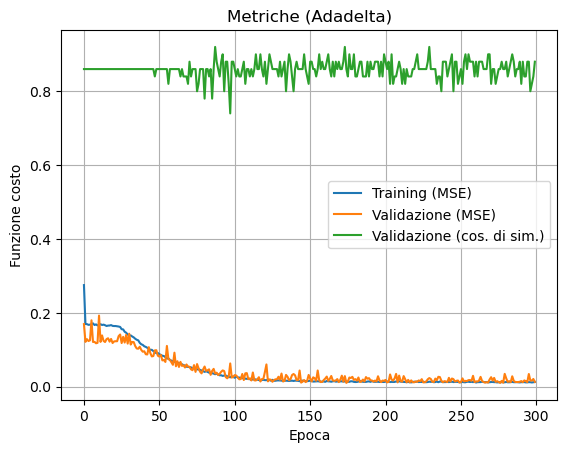

In [23]:
# summarize history for loss
plt.plot(history_adadelta.history['loss'])
plt.plot(history_adadelta.history['val_loss'])
plt.plot(history_adadelta.history['val_cosine_similarity'])
plt.ylabel('Funzione costo')
plt.xlabel('Epoca')
plt.legend(['Training (MSE)', 'Validazione (MSE)', "Validazione (cos. di sim.)"], loc='best')
plt.title("Metriche (Adadelta)")
plt.grid()
plt.show()

Qui vediamo l'andamento che ci aspettiamo: in particolare l'errore quadratico medio di validazione è più grande di quello di training, eccetto che per un breve periodo all'inizio dell'ottimizzazione. Osserviamo anche che l'andamento dell'errore di validazione non ci fa pensare che si sia verificato overtraining.

Ora confronto le previsioni del modello con i dati esatti:

In [24]:
X = np.linspace(-1.5, 1.5, 50)
Y = np.linspace(-1.5, 1.5, 50)
X_pred, Y_pred = np.meshgrid(X, Y)
Z_model = f(X_pred, Y_pred)
xs = np.array(list(zip(X_pred.flatten(), Y_pred.flatten())))
Z_pred = model_adadelta.predict(xs)
Z_pred = np.reshape(Z_pred, (50, 50))

79/79 [==============================] - 0s 1ms/step


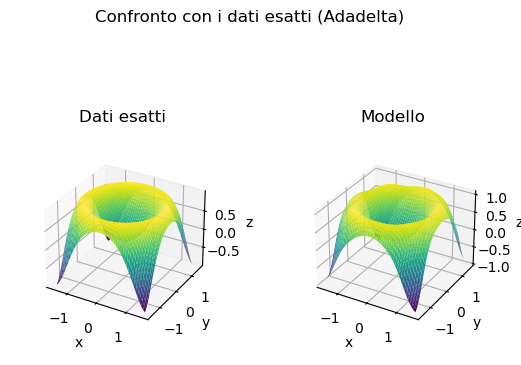

In [25]:
fig=plt.figure()
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(X_pred, Y_pred, Z_model, rstride=1, cstride=1,
                cmap="viridis", edgecolor='none')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_title("Dati esatti")
ax.set_box_aspect(None, zoom=0.80)
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_surface(X_pred, Y_pred, Z_pred, rstride=1, cstride=1,
                cmap="viridis", edgecolor='none')
fig.suptitle("Confronto con i dati esatti (Adadelta)")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_title("Modello")
ax.set_box_aspect(None, zoom=0.80)

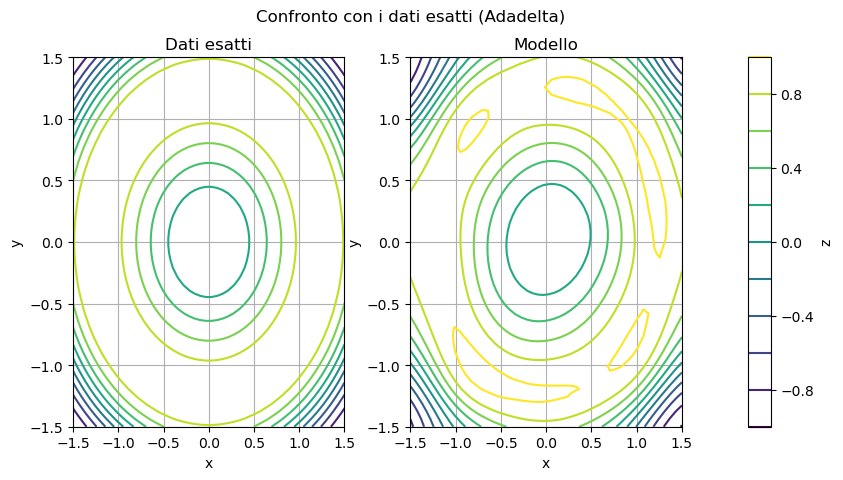

In [26]:
fig, (ax1, ax2, cbar_ax) = plt.subplots(
    nrows=1,
    ncols=3,
    figsize=(9, 4.8), 
    gridspec_kw={
        "width_ratios":[0.48, 0.48, 0.04],
        "wspace":0.35
    }
)
ax1.contour(X_pred, Y_pred, Z_model, levels=np.linspace(-1, 1, 11))
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_title("Dati esatti")
c = ax2.contour(X_pred, Y_pred, Z_pred, levels=np.linspace(-1, 1, 11))
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_title("Modello")
fig.colorbar(c, cax=cbar_ax, label="z")
fig.suptitle("Confronto con i dati esatti (Adadelta)")
ax1.grid()
ax2.grid()

Vediamo che il fit è discreto.

### Ottimizzazione con Adadelta, più parametri

Ora proviamo ad aumentare significativamente la complessità del modello, per provare ad osservare il fenomeno dell'overfitting. Definisco ed addestro il modello:

In [27]:
model_overfit = tf.keras.Sequential()
model_overfit.add(Dense(32, input_shape=(2, ), activation="tanh"))
model_overfit.add(Dense(32, activation="tanh"))
model_overfit.add(Dense(32, activation="tanh"))
model_overfit.add(Dense(32, activation="tanh"))
model_overfit.add(Dense(32, activation="tanh"))
model_overfit.add(Dense(32, activation="tanh"))
model_overfit.add(Dense(32, activation="tanh"))
model_overfit.add(Dense(32, activation="tanh"))
model_overfit.add(Dense(32, activation="tanh"))
model_overfit.add(Dense(1))

In [28]:
model_overfit.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 32)                96        
                                                                 
 dense_9 (Dense)             (None, 32)                1056      
                                                                 
 dense_10 (Dense)            (None, 32)                1056      
                                                                 
 dense_11 (Dense)            (None, 32)                1056      
                                                                 
 dense_12 (Dense)            (None, 32)                1056      
                                                                 
 dense_13 (Dense)            (None, 32)                1056      
                                                                 
 dense_14 (Dense)            (None, 32)               

In [29]:
opt = keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
model_overfit.compile(
    optimizer=opt,
    loss=keras.losses.MeanSquaredError(),
    metrics = ["cosine_similarity"]
)

In [30]:
history_overfit = model_overfit.fit(
    x=x_train,
    y=y_train,
    batch_size=32,
    epochs=400,
    validation_data=(x_test, y_test)
)

Epoch 1/400
32/32 [==============================] - 1s 8ms/step - loss: 0.2370 - cosine_similarity: 0.7600 - val_loss: 0.1761 - val_cosine_similarity: 0.8600
Epoch 2/400
32/32 [==============================] - 0s 3ms/step - loss: 0.1732 - cosine_similarity: 0.8400 - val_loss: 0.1194 - val_cosine_similarity: 0.8600
Epoch 3/400
32/32 [==============================] - 0s 3ms/step - loss: 0.1716 - cosine_similarity: 0.8400 - val_loss: 0.1357 - val_cosine_similarity: 0.8600
Epoch 4/400
32/32 [==============================] - 0s 3ms/step - loss: 0.1680 - cosine_similarity: 0.8400 - val_loss: 0.1443 - val_cosine_similarity: 0.8600
Epoch 5/400
32/32 [==============================] - 0s 3ms/step - loss: 0.1680 - cosine_similarity: 0.8400 - val_loss: 0.1166 - val_cosine_similarity: 0.8600
Epoch 6/400
32/32 [==============================] - 0s 3ms/step - loss: 0.1691 - cosine_similarity: 0.8400 - val_loss: 0.1667 - val_cosine_similarity: 0.8600
Epoch 7/400
32/32 [===========================

In [31]:
mse, cos_sim = model_overfit.evaluate(x_test, y_test, batch_size=32, verbose=1)
print()
print("Metriche di validazione:")
print("MSE:", mse)
print("Coseno di similitudine: ", cos_sim)

4/4 [==============================] - 0s 2ms/step - loss: 0.0202 - cosine_similarity: 0.8600

Metriche di validazione:
MSE: 0.020152049139142036
Coseno di similitudine:  0.8600000143051147


Disegno il grafico delle metriche di validazione:

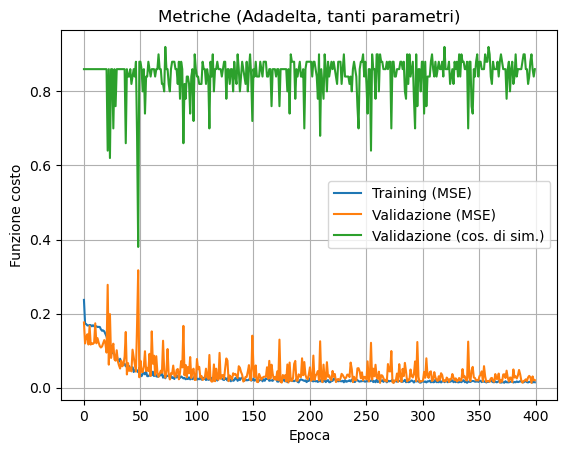

In [36]:
# summarize history for loss
plt.plot(history_overfit.history['loss'])
plt.plot(history_overfit.history['val_loss'])
plt.plot(history_overfit.history['val_cosine_similarity'])
plt.ylabel('Funzione costo')
plt.xlabel('Epoca')
plt.legend(['Training (MSE)', 'Validazione (MSE)', "Validazione (cos. di sim.)"], loc='best')
plt.title("Metriche (Adadelta, tanti parametri)")
plt.grid()
plt.show()

Anche qui vediamo l'andamento che ci aspettiamo, ma osserviamo anche che le metriche di validazione sono significativamente più rumorose che nei casi prcedenti.

Ora confronto le previsioni del modello con i dati esatti:

In [33]:
X = np.linspace(-1.5, 1.5, 50)
Y = np.linspace(-1.5, 1.5, 50)
X_pred, Y_pred = np.meshgrid(X, Y)
Z_model = f(X_pred, Y_pred)
xs = np.array(list(zip(X_pred.flatten(), Y_pred.flatten())))
Z_pred = model_overfit.predict(xs)
Z_pred = np.reshape(Z_pred, (50, 50))

79/79 [==============================] - 0s 983us/step


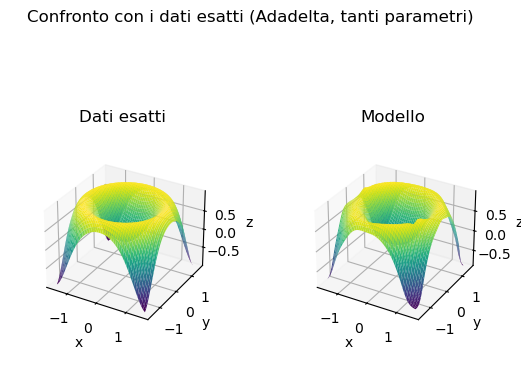

In [34]:
fig=plt.figure()
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(X_pred, Y_pred, Z_model, rstride=1, cstride=1,
                cmap="viridis", edgecolor='none')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_title("Dati esatti")
ax.set_box_aspect(None, zoom=0.80)
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_surface(X_pred, Y_pred, Z_pred, rstride=1, cstride=1,
                cmap="viridis", edgecolor='none')
fig.suptitle("Confronto con i dati esatti (Adadelta, tanti parametri)")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_title("Modello")
ax.set_box_aspect(None, zoom=0.80)

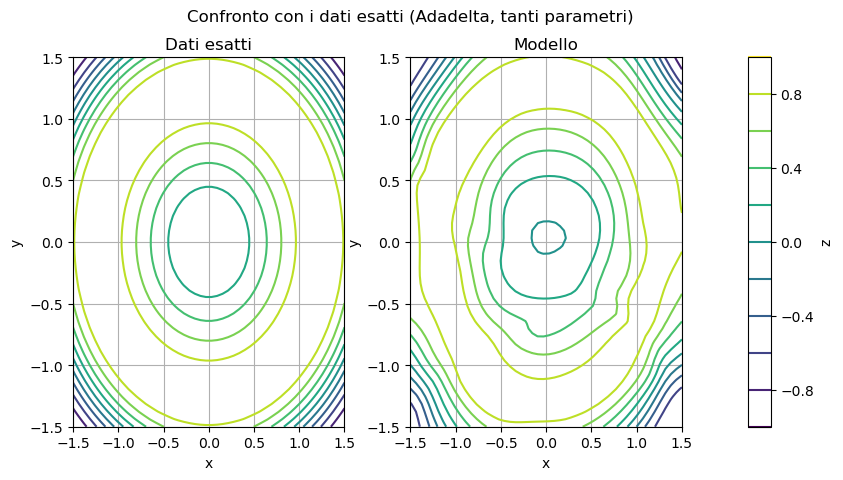

In [35]:
fig, (ax1, ax2, cbar_ax) = plt.subplots(
    nrows=1,
    ncols=3,
    figsize=(9, 4.8), 
    gridspec_kw={
        "width_ratios":[0.48, 0.48, 0.04],
        "wspace":0.35
    }
)
ax1.contour(X_pred, Y_pred, Z_model, levels=np.linspace(-1, 1, 11))
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_title("Dati esatti")
c = ax2.contour(X_pred, Y_pred, Z_pred, levels=np.linspace(-1, 1, 11))
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_title("Modello")
fig.colorbar(c, cax=cbar_ax, label="z")
fig.suptitle("Confronto con i dati esatti (Adadelta, tanti parametri)")
ax1.grid()
ax2.grid()

Qui vediamo che le curve di livello dei dati generati dal modello sono più irregolari che nel caso precedente, segno che il modello ha "imparato" alcune delle caratteristiche del rumore aggiunto ai dati di training.